In [52]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import seaborn as sns
import pandas as pd
markers = itertools.cycle(['o','s','v', '+'])
#%matplotlib

directory = "../results/disorder/PBC/"

In [2]:
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += str(ele)  
    
    # return string  
    return str1 

In [35]:
def filesToDataFrame(directory, file_begin, L_chain, distinguisher : str):
    df = pd.DataFrame()
    for filename in os.listdir(directory):
        if filename[-4:] != ".dat":
            continue
        splitter = filename[:-4].split("_")
        params = splitter[-1].split(",")

        L = 0
        g = 0
        h = 0
        w = 0
        label = ""
        skip = False
        
        for item in params:                           # take the parameters divided by commas, last split is because we have .dat
            split_item = item.split("=")                  # take values for the parameters
            #print(split_item)
            if split_item[0] == "L":
                L = int(split_item[1])
                if L != L_chain:
                    skip = True
                    break
            elif split_item[0] == "h":
                h = float(split_item[1])
                if distinguisher == split_item[0]:
                    label = item
            elif split_item[0] == "g":
                g = float(split_item[1])
                if distinguisher == split_item[0]:
                    label = item
            elif split_item[0] == "w":
                w = float(split_item[1])
                if distinguisher == split_item[0]:
                    label = item
        #print(splitter[0])
        if splitter[0] == file_begin and not skip:
            tmp = pd.read_csv(directory + filename, sep = "\t\t", names = ["proba",label])
            #print(directory + filename)
            #print(tmp)
            #tmp.dropna()
            tmp = tmp.astype(float)
            #print(tmp)
            df['proba']= tmp["proba"]
            df[label] = tmp[label]
    df.index = df['proba']
    df.drop(columns = ['proba'], inplace = True)
    return df.astype(float)
                    
df = filesToDataFrame(directory + "./", "ProbDistSigmaX", 12, "w")  
#print(df)
#print(df.where(df["w=0.00"] > 0).dropna())
df             

<ipython-input-35-193f74ce3a0a>:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = "\t\t", names = ["proba",label])


,w=0.00,w=0.10,w=0.20,w=0.30,w=0.40,w=0.50,w=0.60,w=0.70,w=0.80,w=0.90,...,w=3.40,w=3.50,w=3.60,w=3.70,w=3.80,w=3.90,w=4.00,w=4.10,w=4.20,w=4.30
proba,,,,,,,,,,,,,,,,,,,,,
-0.500,1.1000,0.0300,0.0000,0.0000,0.0000,0.0,0.0025,0.0150,0.0125,0.0125,...,4.5800,4.7000,4.7925,4.7100,4.4150,4.7700,4.4425,4.2450,4.2225,4.1900
-0.498,1.0375,0.0250,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0100,0.0100,...,4.6175,4.5575,4.6450,4.8550,4.3400,4.6675,4.2575,4.3950,4.2425,4.3975
-0.496,1.0500,0.0225,0.0000,0.0000,0.0000,0.0,0.0050,0.0025,0.0000,0.0125,...,4.7600,4.6825,4.7725,4.8650,4.4975,4.5650,4.4875,4.4250,4.2150,4.4100
-0.494,0.9975,0.0325,0.0025,0.0025,0.0000,0.0,0.0000,0.0050,0.0025,0.0150,...,4.5850,4.5375,4.8825,4.6500,4.5800,4.6425,4.5350,4.4425,4.2225,4.4025
-0.492,1.1175,0.0100,0.0000,0.0000,0.0000,0.0,0.0000,0.0075,0.0125,0.0200,...,4.6700,4.7900,4.7825,4.7550,4.5900,4.7275,4.5375,4.3375,4.1725,4.3650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.492,1.0950,0.0400,0.0000,0.0000,0.0025,0.0,0.0000,0.0050,0.0125,0.0275,...,4.6350,4.6850,4.8225,4.8300,4.6450,4.6500,4.2100,4.3975,4.3350,4.3850
0.494,1.0650,0.0375,0.0075,0.0000,0.0000,0.0,0.0000,0.0000,0.0075,0.0250,...,4.7850,4.7600,4.6950,4.8275,4.4225,4.5200,4.5550,4.4050,4.2000,4.3850
0.496,1.0875,0.0250,0.0000,0.0000,0.0000,0.0,0.0025,0.0025,0.0100,0.0125,...,4.3675,4.9150,4.5450,4.8600,4.4725,4.4950,4.4575,4.2200,4.0725,4.3400


In [51]:
def plotKurtosisFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        kurto = []
        if not pd.empty:
            labels.append("L=" + str(L))
                     
            kurtos = pd.kurtosis(axis = 0)
            #print(kurtos)
            kurto = [a for a in kurtos]
            values = [float(x.split("=")[-1]) for x in kurtos.index]                 # list of possible x_disting values
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            order = np.argsort(values)
            
            
            ax.plot(np.array(values)[order], np.array(kurto)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
                )
    #print(labels)       
    ax.set(title = "kurtosis of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "kurtosis(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([0,4.5])
    #ax.set_ylim([0,4])
    plt.savefig(directory + "kurtosis_" + name_of_file_start + ".png")
    plt.show()

plotKurtosisFromDF(directory + "./", "ProbDistSigmaX", "w", [12])

<ipython-input-35-193f74ce3a0a>:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = "\t\t", names = ["proba",label])


In [50]:

def plotBinderFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        binder = []
        if not pd.empty:
            labels.append("L=" + str(L))
            
            square_pd = pd.apply(np.square, axis =1)
            fourth_pd=square_pd.apply(np.square, axis = 1)
            
            #print(square_pd)
            
            fourth_mean = [fourth_pd[a].mean() for a in fourth_pd.columns]
            square_mean = [square_pd[a].mean() for a in square_pd.columns]

            
            for i in range(len(square_mean)):
                binder.append(1 - fourth_mean[i]/(3*square_mean[i]))
            ##print(binder)
            values = [float(x.split("=")[-1]) for x in pd.columns]                 # list of possible x_disting values
            
            order = np.argsort(values)
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            ax.plot(np.array(values)[order], np.array(binder)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
            )
    #print(labels)       
    ax.set(title = "Binder cumulant of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "U(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([-0,4.5])
    #ax.set_ylim([-80,10])
    plt.savefig(directory + "BinderCumulant_" + name_of_file_start + ".png")
    plt.show()

plotBinderFromDF(directory + "./", "ProbDistSigmaX", "w", [12])

<ipython-input-35-193f74ce3a0a>:38: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = "\t\t", names = ["proba",label])


In [53]:
def plot_av_Sx(w,g, j0,g0 ,h,Ls, directory):
    try:
        plt.clf()
        plt.cla()
        folder = directory + '/sigma_x/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        fig, ax = plt.subplots(figsize=(10,10), dpi = 200)
        legend = []
        title = "Average $S_x$ for w=" + str(w) +",j0="+str(j0)+",g0="+str(g0) + ",g=" + str(g) + ",h=" +str(h)
        savefile = ",w=" + str(w) +",j0="+str(j0)+",g0="+str(g0) + ",g=" + str(g) + ",h=" +str(h)
        for filename in os.listdir(folder):
            #print(filename)
            if ((filename[0:8] == "sigma_x_") and (filename[-4:] == '.txt' or filename[-4:] == '.dat')):
                #print(filename)
                splitter = filename[8:-4].split(',')
                print(splitter)
                # L, g, h, w
                splitter = [float(a.split('=')[-1]) for a in splitter]
                #print(splitter)
                if (splitter[0] in Ls and j0 == splitter[1] and g == splitter[2] and g0 == splitter[3] and h == splitter[4] and w == splitter[5]):
                    #print(splitter)
                    legend.append("L=" + str(splitter[0]))
                    #savefile = "avSx_L=" + str(splitter[0]) 
                    tmp = pd.read_csv(folder + filename, sep = "\t",index_col=0, names = ['E','Sx'])
                    #print(tmp)
                    # PLOT 
                    tmp.plot(ax = ax
                            , linewidth=0.75
                            , marker=next(markers)
                            , markersize=2)
                    
        ax.set(title = title
            , xlabel = "eigenenergy"
            , ylabel = "<n|$S_x$|n>")
        ax.legend(legend
              , frameon=False
              , loc='best'
              , fontsize=8)
        ax.set_xlim([-0.5,0.5])
        #ax.set_ylim([-0.3,0.3])
        plt.savefig(folder + savefile[:-1] + ".png")
        plt.show()

                    
plot_av_Sx(1.0,1.0,0.2,0.0,0.0,[11,12,13],"../results/disorder/PBC/")    

['gif']


ValueError: could not convert string to float: 'gif'

[12.0, 0.9, 0.0]


<ipython-input-9-2f188b0074b9>:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(folder + filename, sep = "\t\t", names = ['w','bucket','r'])


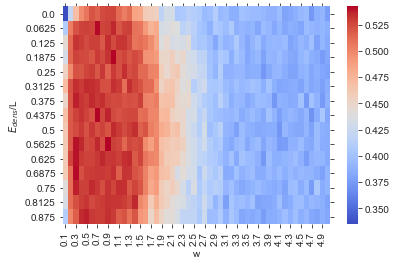

In [9]:
def plot_r_phase(L,g,h, directory):
    try:
        plt.clf()
        plt.cla()
        folder = directory + '/r_phase/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        #fig, ax = plt.subplots()
        title = "r participation for L=" + str(L) + ", g=" + str(g) + ", h=" +str(h) 
        savefile = "r_L=" + str(L) + ",g=" + str(g) + ",h=" +str(h)
        for filename in os.listdir(folder):
            if (filename.startswith("PhaseDiagram") and (filename[-4:] == '.txt' or filename[-4:] == '.dat')):
                splitter = filename[:-4].split('_')[-1].split(',')
                # L, g, h, w
                splitter = [float(a.split('=')[-1]) for a in splitter]
                if (L == splitter[0] and g == splitter[1] and h == splitter[2]):
                    print(splitter)
                    tmp = pd.read_csv(folder + filename, sep = "\t\t", names = ['w','bucket','r'])
                    tmp.dropna()
                    #print(tmp)
                    tmp = tmp[tmp['r'] != 0.0]

                    #print(tmp)
                    pivotted= tmp.pivot('bucket','w','r')
                    # PLOT 
                    r = np.array(tmp['r'])
                    
                    sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(r), vmax=np.max(r))
                    
    
    plt.ylabel("$E_{dens}$/L")
    plt.savefig(folder + savefile + ".png")
    plt.show()                


                    
plot_r_phase(12,0.9,0.0,"../results/disorder/") 